In [1]:
import shutil
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

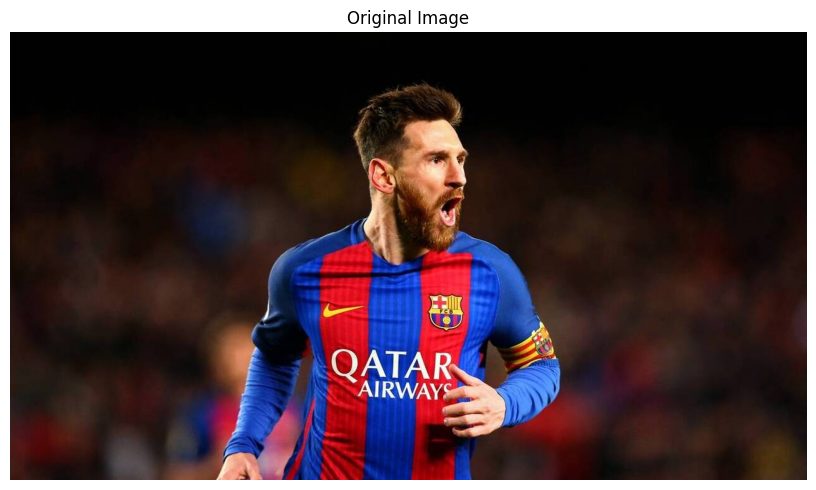

In [2]:
img = cv2.imread('data/messidos.jpeg',1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 5))
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()

https://medium.com/nerd-for-tech/cartoonize-images-with-python-10e2a466b5fb

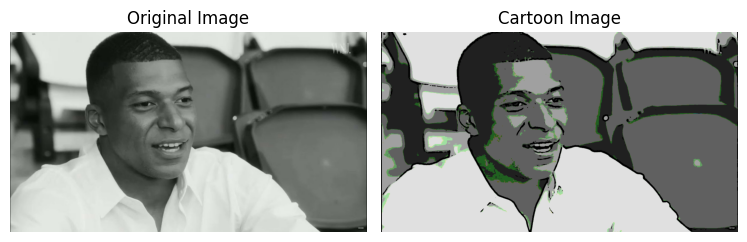

In [3]:
def generate_cartoon_image(image_path, output_path):
    """
    Converts an input image into a cartoon-style image using filtering, edge detection,
    color quantization, and mask combination.

    Parameters:
        image_path (str): Path to the input image.
        output_path (str): Path to save the resulting cartoon image.

    Returns:
        None
    """
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply filters to reduce noise
    img_gb = cv2.GaussianBlur(img, (7, 7), 0)
    img_mb = cv2.medianBlur(img_gb, 5)
    img_bf = cv2.bilateralFilter(img_mb, 5, 80, 80)

    # Apply Laplacian edge detection
    img_lp_bf = cv2.Laplacian(img_bf, cv2.CV_8U, ksize=5)

    # Convert the edge-detected image to grayscale
    img_lp_bf_gray = cv2.cvtColor(img_lp_bf, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur and Otsu's thresholding
    blur_bf = cv2.GaussianBlur(img_lp_bf_gray, (5, 5), 0)
    _, thresh_bf = cv2.threshold(blur_bf, 245, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert the binary mask
    inverted_mask = cv2.subtract(255, thresh_bf)

    # Convert the mask to color
    inverted_mask_color = cv2.cvtColor(inverted_mask, cv2.COLOR_GRAY2RGB)

    # Perform color quantization using simple floor division
    div = 64
    img_bins = img // div * div + div // 2

    # Combine the mask with the quantized image
    cartoon_image = cv2.bitwise_and(inverted_mask_color, img_bins)
    # cartoon_image = cv2.cvtColor(cartoon_image, cv2.COLOR_RGB2BGR)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('Cartoon Image')
    plt.imshow(cartoon_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    cartoon_image = cv2.cvtColor(cartoon_image, cv2.COLOR_RGB2BGR)
    # Save the final cartoon-style image
    cv2.imwrite(output_path, cartoon_image)


generate_cartoon_image('data/mbappe.jpg', 'CartoonImage1.jpg')

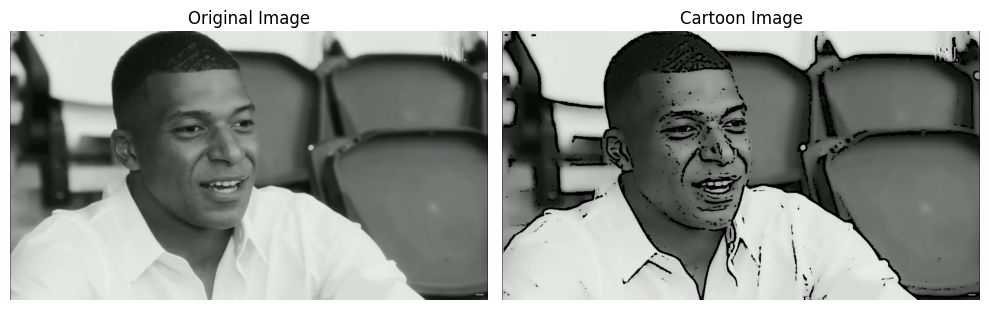

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_cartoon_image_v1(image_path, output_path):
    """
    Converts an image into a cartoon-style image with bold edges and simplified colors.

    Parameters:
        image_path (str): Path to the input image.
        output_path (str): Path to save the cartoon image.

    Returns:
        None
    """
    # Load and convert the image to RGB
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Use bilateral filter to reduce color noise while keeping edges sharp
    img_filtered = cv2.bilateralFilter(img_rgb, d=9, sigmaColor=75, sigmaSpace=75)

    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(img_filtered, cv2.COLOR_RGB2GRAY)

    # Use adaptive thresholding to create an edge mask
    edges = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize=9, C=2
    )

    # Convert edge mask to color
    edges_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    # Combine edge mask with the filtered image
    cartoon = cv2.bitwise_and(img_filtered, edges_color)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Cartoon Image')
    plt.imshow(cartoon)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the result
    cartoon_bgr = cv2.cvtColor(cartoon, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, cartoon_bgr)

generate_cartoon_image_v1('data/mbappe.jpg', 'CartoonImage_1_v1.jpg')


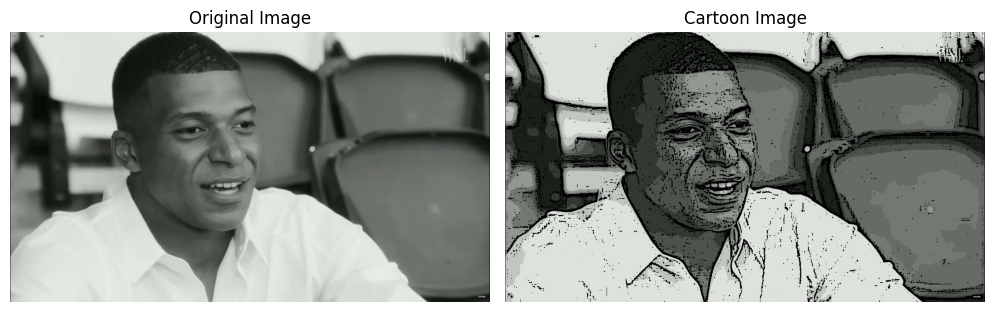

In [5]:
def generate_cartoon_image_v1_1(image_path, output_path):
    """
    Refined cartoon effect with bold edges, simplified color palette, and optional stylization.

    Parameters:
        image_path (str): Path to the input image.
        output_path (str): Path to save the cartoon image.

    Returns:
        None
    """
    # Load and convert the image to RGB
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply bilateral filter to reduce noise while keeping edges sharp
    img_filtered = cv2.bilateralFilter(img_rgb, d=9, sigmaColor=75, sigmaSpace=75)

    # Apply color quantization (reduce colors for a hand-drawn look)
    def color_quantization(image, k=8):
        data = np.float32(image).reshape((-1, 3))
        _, labels, centers = cv2.kmeans(
            data, k, None,
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
            attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS
        )
        quantized = centers[labels.flatten()].reshape(image.shape)
        return np.uint8(quantized)

    img_quantized = color_quantization(img_filtered)

    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # Apply adaptive thresholding for bold edges
    edges = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize=9, C=2
    )

    # Convert edges to a 3-channel image
    edges_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    # Combine quantized colors with edges
    cartoon = cv2.bitwise_and(img_quantized, edges_color)


    # Display results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Cartoon Image')
    plt.imshow(cartoon)
    plt.axis('off')


    plt.tight_layout()
    plt.show()

    # Save the final image (choose between cartoon or stylized cartoon)
    cartoon_bgr = cv2.cvtColor(cartoon, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, cartoon_bgr)

generate_cartoon_image_v1_1('data/mbappe.jpg', 'CartoonImage_v1_1.jpg')


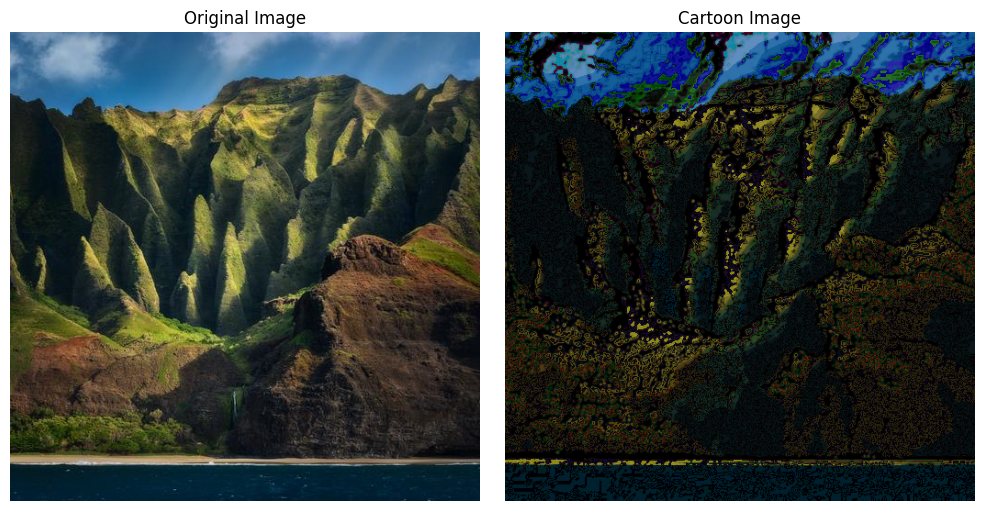

In [26]:
def generate_cartoon_image_v2(image_path, output_path):
    """
    Refined cartoon effect with vibrant colors and reduced edge sensitivity.

    Parameters:
        image_path (str): Path to the input image.
        output_path (str): Path to save the cartoon image.

    Returns:
        None
    """
    # Load and convert the image to RGB
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply bilateral filter to reduce noise while keeping edges smooth
    img_filtered = cv2.bilateralFilter(img_rgb, d=15, sigmaColor=150, sigmaSpace=150)

    # Boost color saturation
    img_hsv = cv2.cvtColor(img_filtered, cv2.COLOR_RGB2HSV)
    img_hsv[:, :, 1] = cv2.add(img_hsv[:, :, 1], 50)  # Increase saturation
    img_vibrant = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

    # Apply color quantization (reduce colors for a smoother look)
    def color_quantization(image, k=12):
        data = np.float32(image).reshape((-1, 3))
        _, labels, centers = cv2.kmeans(
            data, k, None,
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
            attempts=10, flags=cv2.KMEANS_RANDOM_CENTERS
        )
        quantized = centers[labels.flatten()].reshape(image.shape)
        return np.uint8(quantized)

    img_quantized = color_quantization(img_vibrant)

    # Convert to grayscale and apply a soft edge detection using Sobel filter
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_8U, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_8U, 0, 1, ksize=5)
    edges = cv2.bitwise_or(sobelx, sobely)

    # Invert edges and reduce their intensity
    edges = cv2.bitwise_not(edges)
    edges = cv2.GaussianBlur(edges, (5, 5), 0)

    # Convert edges to a 3-channel image
    edges_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    # Combine the vibrant, quantized image with soft edges
    cartoon = cv2.bitwise_and(img_quantized, edges_color)

    # Display results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Cartoon Image')
    plt.imshow(cartoon)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the final image
    cartoon_bgr = cv2.cvtColor(cartoon, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, cartoon_bgr)

generate_cartoon_image_v2('data/10016.jpg', 'CartoonImage_v2.jpg')


In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

def cartoon_style_method1(image_path, output_path):
    """
    Cartoon style conversion using edge preservation and color simplification.
    Creates a more painterly, artistic cartoon effect.
    """
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Downsample the image to reduce detail
    small = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
    
    # Bilateral filtering for edge preservation
    for _ in range(5):
        small = cv2.bilateralFilter(small, 9, 75, 75)
    
    # Upsample back to original size
    small = cv2.resize(small, (img.shape[1], img.shape[0]))
    
    # Edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.adaptiveThreshold(
        gray, 255, 
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY, 9, 7
    )
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    
    # Combine the smoothed image with edges
    cartoon = cv2.bitwise_and(small, edges)
    
    # Visualize and save
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Cartoon Style')
    plt.imshow(cartoon)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Convert back to BGR for saving
    cartoon_bgr = cv2.cvtColor(cartoon, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, cartoon_bgr)
    
    return cartoon

def cartoon_style_method2(image_path, output_path):
    """
    Advanced cartoon style conversion with more pronounced stylization.
    Emphasizes color blocks and strong edge detection.
    """
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Reduce color palette
    data = img.reshape((-1, 3))
    data = np.float32(data)
    
    # Define criteria and apply k-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 8  # Number of color clusters
    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert back to 8-bit values
    centers = np.uint8(centers)
    reduced = centers[labels.flatten()]
    reduced = reduced.reshape(img.shape)
    
    # Edge detection with thicker lines
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges = cv2.dilate(edges, None)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    edges = edges * 255  # Make edges more prominent
    
    # Combine color-reduced image with edges
    cartoon = cv2.addWeighted(reduced, 0.8, edges, 0.2, 0)
    
    # Visualize and save
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Cartoon Style')
    plt.imshow(cartoon)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Convert back to BGR for saving
    cartoon_bgr = cv2.cvtColor(cartoon, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, cartoon_bgr)
    
    return cartoon

def cartoon_style_method3(image_path, output_path):
    """
    Watercolor-like cartoon style with soft edges and color blending.
    """
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Reduce image resolution for a more stylized look
    small = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
    
    # Apply multiple bilateral filters for a painterly effect
    for _ in range(7):
        small = cv2.bilateralFilter(small, 13, 85, 85)
    
    # Resize back to original dimensions
    blended = cv2.resize(small, (img.shape[1], img.shape[0]))
    
    # Soft edge detection with Sobel operators
    gray = cv2.cvtColor(blended, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Combine Sobel edges
    edges = np.sqrt(sobelx**2 + sobely**2)
    edges = (edges / np.max(edges) * 255).astype(np.uint8)
    edges = cv2.GaussianBlur(edges, (3, 3), 0)
    
    # Create a soft edge mask
    _, edge_mask = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY_INV)
    edge_mask = cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB)
    
    # Blend original colors with soft edges
    cartoon = cv2.bitwise_and(blended, edge_mask)
    
    # Visualize and save
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Cartoon Style')
    plt.imshow(cartoon)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Convert back to BGR for saving
    cartoon = cv2.cvtColor(cartoon, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, cartoon)
    



In [47]:
import cv2
import numpy as np

def cartoon_style_method2(image_path, output_path):
    """
    Advanced cartoon style conversion with more pronounced stylization.
    Emphasizes color blocks and strong edge detection.
    """
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reduce color palette
    data = img.reshape((-1, 3))
    data = np.float32(data)

    # Define criteria and apply k-means clustering with more color clusters
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 16  # Increase the number of color clusters
    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to 8-bit values
    centers = np.uint8(centers)
    reduced = centers[labels.flatten()]
    reduced = reduced.reshape(img.shape)

    # Edge detection with thicker lines
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges = cv2.dilate(edges, None, iterations=2)  # Increase the dilation to make edges thicker
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    edges = edges * 255  # Make edges more prominent

    # Apply bilateral filtering to smooth the image while preserving edges
    smoothed = cv2.bilateralFilter(reduced, 7, 75, 75)

    # Combine color-reduced and smoothed image with edges
    cartoon = cv2.addWeighted(smoothed, 0.8, edges, 0.2, 0)

        # Visualize and save
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Cartoon Style')
    plt.imshow(cartoon)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    

    # Convert back to BGR for saving
    cartoon_bgr = cv2.cvtColor(cartoon, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, cartoon_bgr)

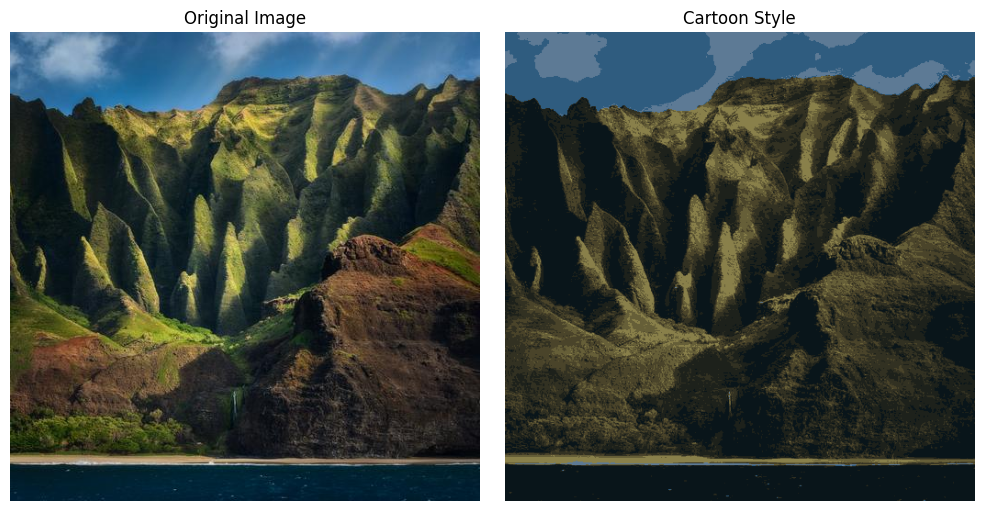

array([[[ 47,  92, 127],
        [ 47,  92, 127],
        [ 47,  92, 127],
        ...,
        [ 47,  92, 127],
        [ 47,  92, 127],
        [ 47,  92, 127]],

       [[ 47,  92, 127],
        [ 47,  92, 127],
        [ 47,  92, 127],
        ...,
        [ 47,  92, 127],
        [ 47,  92, 127],
        [ 47,  92, 127]],

       [[ 47,  92, 127],
        [ 47,  92, 127],
        [ 47,  92, 127],
        ...,
        [ 47,  92, 127],
        [ 47,  92, 127],
        [ 47,  92, 127]],

       ...,

       [[  9,  21,  26],
        [  9,  21,  26],
        [  9,  21,  26],
        ...,
        [  9,  21,  26],
        [  9,  21,  26],
        [  9,  21,  26]],

       [[  9,  21,  26],
        [  9,  21,  26],
        [  9,  21,  26],
        ...,
        [  9,  21,  26],
        [  9,  21,  26],
        [  9,  21,  26]],

       [[  9,  21,  26],
        [  9,  21,  26],
        [  9,  21,  26],
        ...,
        [  9,  21,  26],
        [  9,  21,  26],
        [  9,  21,  26]]

In [50]:
cartoon_style_method2('data/10016.jpg', 'CartoonImage2.jpg')

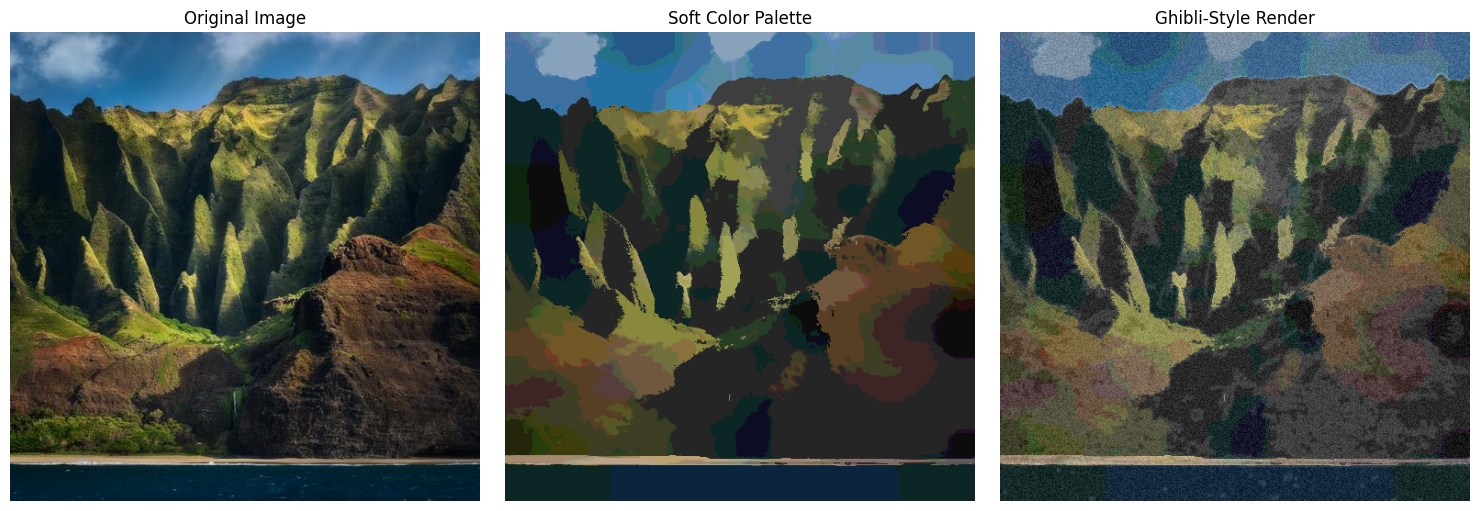

array([[[ 94, 115, 156],
        [ 95, 116, 156],
        [ 71,  92, 132],
        ...,
        [ 52,  92, 132],
        [ 50,  91, 132],
        [ 51,  92, 132]],

       [[ 95, 116, 156],
        [ 72,  93, 133],
        [ 96, 116, 157],
        ...,
        [ 50,  91, 132],
        [ 51,  91, 132],
        [ 50,  91, 131]],

       [[ 75, 115, 156],
        [ 71,  92, 132],
        [ 71,  92, 132],
        ...,
        [ 76, 116, 156],
        [ 51,  91, 132],
        [ 75, 116, 156]],

       ...,

       [[ 35,  55,  55],
        [ 35,  55,  55],
        [ 12,  32,  32],
        ...,
        [ 10,  30,  30],
        [ 35,  55,  55],
        [ 10,  30,  30]],

       [[ 35,  55,  55],
        [ 10,  30,  30],
        [ 35,  55,  55],
        ...,
        [ 10,  30,  30],
        [ 10,  30,  30],
        [ 35,  54,  54]],

       [[ 10,  30,  30],
        [ 34,  54,  54],
        [ 10,  30,  30],
        ...,
        [ 10,  30,  30],
        [ 35,  55,  55],
        [ 12,  31,  31]]

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ghibli_style_renderer(image_path, output_path):
    """
    Render an image in a Studio Ghibli-inspired style.
    Captures key characteristics of Ghibli's hand-drawn aesthetic.
    """
    # Read the original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 1. Color Palette Transformation
    # Mimic Ghibli's soft, watercolor-like color palette
    def soft_color_palette(image):
        # Reduce color complexity while maintaining soft gradients
        smoothed = cv2.pyrMeanShiftFiltering(image, sp=21, sr=51)
        
        # Apply a soft color quantization
        reduced = smoothed.copy()
        reduced = reduced // 25 * 25 + 12  # Soft color blocks
        return reduced
    
    # 2. Edge and Texture Rendering
    def ghibli_edge_rendering(image):
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Soft edge detection - mimicking hand-drawn line quality
        edges = cv2.Canny(gray, 50, 150)
        
        # Soften and thicken edges
        edges = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=1)
        edges = cv2.GaussianBlur(edges, (3, 3), 0)
        
        return edges
    
    # 3. Texture Overlay - Mimicking watercolor paper texture
    def add_texture_overlay(image):
        # Create a subtle texture
        texture = np.random.normal(0, 10, image.shape[:2]).astype(np.uint8)
        texture = cv2.cvtColor(texture, cv2.COLOR_GRAY2RGB)
        
        # Blend texture softly
        textured = cv2.addWeighted(image, 0.9, texture, 0.1, 0)
        return textured
    
    # 4. Ghibli-style Rendering Pipeline
    # Soft color palette
    soft_colors = soft_color_palette(img)
    
    # Edge rendering
    edges = ghibli_edge_rendering(img)
    edges_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    
    # Combine soft colors with subtle edges
    ghibli_style = cv2.addWeighted(soft_colors, 0.9, edges_color, 0.1, 0)
    
    # Add subtle texture
    final_image = add_texture_overlay(ghibli_style)
    
    # Visualization
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Soft Color Palette')
    plt.imshow(soft_colors)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Ghibli-Style Render')
    plt.imshow(final_image)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save the image
    final_image_bgr = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, final_image_bgr)
    
    return final_image

def ghibli_background_renderer(width, height):
    """
    Generate a Ghibli-inspired background with soft watercolor effects.
    """
    # Create a base background
    background = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Soft color gradient - typical of Ghibli backgrounds
    for y in range(height):
        # Create a soft vertical gradient
        r = int(255 * (1 - y/height))
        g = int(200 * (1 - y/height))
        b = int(150 * (1 - y/height))
        background[y, :] = [r, g, b]
    
    # Add watercolor-like noise
    noise = np.random.normal(0, 20, (height, width, 3)).astype(np.uint8)
    background = cv2.addWeighted(background, 0.9, noise, 0.1, 0)
    
    # Soft light effects
    light_overlay = np.zeros_like(background)
    cv2.ellipse(light_overlay, 
                (width//2, height//2), 
                (width//3, height//2), 
                0, 0, 360, 
                (255, 255, 200), 
                -1)
    
    background = cv2.addWeighted(background, 0.8, light_overlay, 0.2, 0)
    
    plt.figure(figsize=(10, 5))
    plt.title('Ghibli-Inspired Background')
    plt.imshow(background)
    plt.axis('off')
    plt.show()
    
    return background

# Example usage
ghibli_style_renderer('data/10016.jpg', 'ghibli_style_output.jpg')
# ghibli_background_renderer(800, 600)

In [ ]:
# import os
# import shutil

# def extract_and_save_files_with_view(source_folder, target_folder):
#     """
#     Extracts files containing the word 'view' from subfolders of a source folder 
#     and saves them in a target folder, ignoring files that are already present 
#     in the target folder.

#     Parameters:
#         source_folder (str): Path to the source folder containing subfolders with files.
#         target_folder (str): Path to the target folder where filtered files will be saved.

#     Returns:
#         None
#     """
#     # Ensure the target folder exists
#     if not os.path.exists(target_folder):
#         os.makedirs(target_folder)

#     # Walk through the source folder and its subfolders
#     for root, _, files in os.walk(source_folder):
#         for file in files:
#             # Check if 'view' is present as a separate word in the filename
#             if 'view' not in file.lower():
#                 continue
            
#             # Construct the destination path in the target folder
#             destination_path = os.path.join(target_folder, file)

#             # Skip if the file already exists in the target folder
#             if os.path.exists(destination_path):
#                 print(f"Skipped: {destination_path} (already exists)")
#                 continue
            
#             # Construct the full file path
#             file_path = os.path.join(root, file)
            
#             # Copy the file to the target folder
#             shutil.copy2(file_path, destination_path)
#             print(f"Copied: {file_path} -> {destination_path}")

#     print(f"Files containing 'view' have been extracted to: {target_folder}")

# # Define the source folder and the target folder
# source_folder = "data/automobiles"
# target_folder = "data/train_original_images"

# # Extract and save files containing the word 'view'
# extract_and_save_files_with_view(source_folder, target_folder)


Skipped: data/train_original_images\2024 Acura ADX Front View.jpg (already exists)
Skipped: data/train_original_images\2024 Acura ADX Rear View.jpg (already exists)
Skipped: data/train_original_images\2024 Acura ADX Side View.jpg (already exists)
Skipped: data/train_original_images\2022 Acura ILX Front View.jpg (already exists)
Skipped: data/train_original_images\2022 Acura ILX Rear View.jpg (already exists)
Skipped: data/train_original_images\2022 Acura ILX Side View Driving.jpg (already exists)
Skipped: data/train_original_images\2023 Acura Integra Sedan Front View.jpg (already exists)
Skipped: data/train_original_images\2023 Acura Integra Sedan Rear Angle View.jpg (already exists)
Skipped: data/train_original_images\2023 Acura Integra Sedan Side View.jpg (already exists)
Skipped: data/train_original_images\2024 Acura Integra Type S Interior Overview.jpg (already exists)
Skipped: data/train_original_images\2024 Acura Integra Type S Rear View.jpg (already exists)
Skipped: data/train_o

In [ ]:
import os

def process_folder_and_save_cartoon_images(source_folder, target_folder):
    """
    Processes all images in the source folder, generates cartoon images,
    and saves them to the target folder, skipping files that are already present.

    Parameters:
        source_folder (str): Path to the source folder containing images.
        target_folder (str): Path to the target folder to save cartoon images.

    Returns:
        None
    """
    # Ensure the target folder exists
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Iterate through all files in the source folder
    for root, _, files in os.walk(source_folder):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                # Define the input and output paths
                image_path = os.path.join(root, file)
                output_path = os.path.join(target_folder, file)
                
                # Skip if the cartoon image already exists
                if os.path.exists(output_path):
                    print(f"Skipped: {output_path} (already exists)")
                    continue

                # Generate and save the cartoon image
                generate_cartoon_image(image_path, output_path)
                print(f"Generated cartoon image: {output_path}")

# Define source and target folders
source_folder = "data/original_images"
target_folder = "data/cartoon_images"

# Process the folder and generate cartoon images
process_folder_and_save_cartoon_images(source_folder, target_folder)


Skipped: data/test_cartoon_images\2020 Acura MDX Sport Hybrid Front View.jpg (already exists)
Skipped: data/test_cartoon_images\2020 Acura MDX Sport Hybrid Interior Overview.jpg (already exists)
Skipped: data/test_cartoon_images\2020 Acura MDX Sport Hybrid Rear Angle View.jpg (already exists)
Skipped: data/test_cartoon_images\2020 Acura MDX Sport Hybrid Side View.jpg (already exists)
Skipped: data/test_cartoon_images\2020 Acura RLX Front View.jpg (already exists)
Skipped: data/test_cartoon_images\2020 Acura RLX Right Side View.jpg (already exists)
Skipped: data/test_cartoon_images\2020 Acura RLX Sport Hybrid Front View.jpg (already exists)
Skipped: data/test_cartoon_images\2020 Acura RLX Sport Hybrid Rear View.jpg (already exists)
Skipped: data/test_cartoon_images\2020 Acura RLX Sport Hybrid Side View.jpg (already exists)
Skipped: data/test_cartoon_images\2020 Alfa Romeo 4C Spider Front View.jpg (already exists)
Skipped: data/test_cartoon_images\2020 Alfa Romeo 4C Spider Rear View.jpg 